# Libraries

Here we store the libraries needed to run patchcore correctly including wich created by us.

In [1]:
# External Modules
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import timm
import time
import utils
import tqdm
import sampler
import patchcore as PatchcoreLib
from numba import jit, cuda
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, confusion_matrix
import os
# Created Modules
import data #load the dataset into data loader
#import network as nn #load the neural network

# GPU
Checking GPU status

In [2]:
print(torch.cuda.is_available())

True


In [3]:
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
#Defining the device
device = torch.device("cuda:0")

In [5]:
torch.cuda.empty_cache()

# Patchcore

In [6]:
# Global variables
RESIZE = 256
IMAGESIZE = 224
PATCHSIZE = 3
PATCHSTRIDE = 1
DILATION = 1
PRETRAIN_EMBED = 1024
TARGET_EMBED = 1024
BATCH_SIZE = 1
PERCENTAGE = 0.1

## Load the datasets

- Loading the desired datasets

In [7]:
selected_data = ['bottle']
datasets =  data.export_data(".\data",selected_data, RESIZE, IMAGESIZE, BATCH_SIZE)

In [8]:
#checking
datasets

{'bottle': {'train': <data.Data at 0x20c9da59730>,
  'test': <data.Data at 0x20c9da59f40>}}

## 2. Autoencoder - ResNet

### Params

- ResNetlike architecture with layers = {1,2,3,4}
- Pathcore uses j and j + 1 layers
- As we want mid-level features, we will use 2 and 3

In [9]:
#In general for Resnet we use those layers.
extract_layers = [2,3]

### Timm Widereset

In [10]:
name = "wide_resnet50_2"
# We need to use timm because we will use pretrained dataset
#Setting the resnet with out_indices that are our mid-level features
neural_network = timm.create_model(name, out_indices = extract_layers, features_only = True, pretrained = True)
neural_network.eval()
neural_network = neural_network.to(device)

### 3. Sampler Definition

In [11]:
# Defining the parameter of the sampler
sampling = sampler.Sampler(PERCENTAGE,device)

### Pathcore Instance

In [12]:
patchcore = PatchcoreLib.Patchcore(neural_network,sampling,
                                RESIZE,IMAGESIZE,PATCHSIZE,PATCHSTRIDE,DILATION,PRETRAIN_EMBED,TARGET_EMBED,
                                device)

### Fitting and testing Patchcore

In [13]:
start_time = time.time()
score_list = {}
for data in datasets:
    print(f"{data} begin at ")
    print("--- %s seconds ---" % (time.time() - start_time))
    patchcore.fit(datasets[data]["train"].dataloader)
    print(f"{data} fit end at ")
    print("--- %s seconds ---" % (time.time() - start_time))
    score_list[data] = patchcore.predict(datasets[data]["test"].dataloader)
    print(f"{data} end at ")
    print("--- %s seconds ---" % (time.time() - start_time))

bottle begin at 
--- 0.0010001659393310547 seconds ---
bottle fit end at 
--- 278.00978446006775 seconds ---
bottle end at 
--- 308.26371908187866 seconds ---


### Analysis of patchcore scores

In [14]:
stat = dict.fromkeys(selected_data, {})

--------RESULTS FOR bottle-----------
roc_auc score: 1.0
We obtain the following plot: 


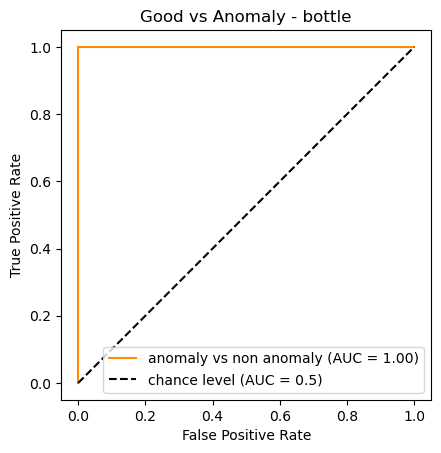

In [15]:
for data in datasets:
    
    print(f"--------RESULTS FOR {data}-----------")
    label =[1 if x["score"][1][0]!="good" else 0 for x in score_list[data]]
    preds = [x["score"][0].to("cpu") for x in score_list[data]]
    label = np.stack(label)
    preds = np.stack(preds)
    stat[data]["roc_auc"] = roc_auc_score(label, preds)
    print(f"roc_auc score: {stat[data]['roc_auc']}")
    print(f"We obtain the following plot: ")
    utils.ROC(label, preds, data)
    image_paths = [os.path.join(".\data",f"{data}","test",x[0],x[1]) for x in datasets[data]["test"].dataloader.dataset.data_to_iterate]
    mask_paths = [x[2] for x in datasets[data]["test"].dataloader.dataset.data_to_iterate]
    image_save_path = f".\\data\\{data}\\segmentation"
    os.makedirs(image_save_path, exist_ok = True)
    mask_list = [x["mask"][0].to("cpu") for x in score_list[data]]
    utils.plot_segmentation_images(datasets,data,image_save_path,image_paths,mask_list,preds,mask_paths)

## Training on different k

In [ ]:
d_k = {1:[],2:[],3:[],4:[],5:[]}
start_time = time.time()
score_list2 = {}
for k in range(2,6):
    
    
    patchcore = PatchcoreLib.Patchcore(neural_network,sampling,
                                    RESIZE,IMAGESIZE,PATCHSIZE,PATCHSTRIDE,DILATION,PRETRAIN_EMBED,TARGET_EMBED,
                                    device,k)
    for data in datasets:
        print(f"{data} begin at ")
        print("--- %s seconds ---" % (time.time() - start_time))
        patchcore.fit(datasets[data]["train"].dataloader)
        print(f"{data} fit end at ")
        print("--- %s seconds ---" % (time.time() - start_time))
        score_list2[data] = patchcore.predict(datasets[data]["test"].dataloader)
        print(f"{data} end at ")
        print("--- %s seconds ---" % (time.time() - start_time))
    
    for data in datasets:
        print(f"--------RESULTS FOR {data}-----------")
        label =[1 if x["score"][1][0]!="good" else 0 for x in score_list2[data]]
        preds = [x["score"][0].to("cpu") for x in score_list2[data]]
        label = np.stack(label)
        preds = np.stack(preds)
        d_k[k].append(roc_auc_score(label, preds))

bottle begin at 
--- 0.0 seconds ---


In [ ]:
with open('k_2.txt','w') as f:
    f.write('dict = ' + str(d_k) + '\n')

## Training on different Percentage

In [ ]:
d_percentage = {str(0.1):[],str(0.25):[],str(0.5):[],str(1):[]}
start_time = time.time()
score_list2 = {}
for per in [1]:
    torch.cuda.empty_cache()
    sampling = sampler.Sampler(per,device)
    patchcore = PatchcoreLib.Patchcore(neural_network,sampling,
                                    RESIZE,IMAGESIZE,PATCHSIZE,PATCHSTRIDE,DILATION,PRETRAIN_EMBED,TARGET_EMBED,
                                    device)
    for data in datasets:
        torch.cuda.empty_cache()
        print(f"{data} begin at ")
        print("--- %s seconds ---" % (time.time() - start_time))
        patchcore.fit(datasets[data]["train"].dataloader)
        print(f"{data} fit end at ")
        print("--- %s seconds ---" % (time.time() - start_time))
        score_list2[data] = patchcore.predict(datasets[data]["test"].dataloader)
        print(f"{data} end at ")
        print("--- %s seconds ---" % (time.time() - start_time))
    
    for data in datasets:
        print(f"--------RESULTS FOR {data}-----------")
        label =[1 if x["score"][1][0]!="good" else 0 for x in score_list2[data]]
        preds = [x["score"][0].to("cpu") for x in score_list2[data]]
        label = np.stack(label)
        preds = np.stack(preds)
        d_percentage[str(per)].append(roc_auc_score(label, preds))

In [ ]:
with open('percentage_3.txt','w') as f:
    f.write('dict = ' + str(d_percentage) + '\n')

### Plotting Hyperparameters Graphs